# The finCEN files: Uncovering money laundering patterns in the global banking network

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/FinCEN.svg" width=250 height=250 /></center>

*21/09/2020*<BR>
The Financial Crimes Enforcement Network (finCEN) files are more than 2,500 documents, most of which were suspicious activity reports (SARs) files that banks sent to the US authorities between 2000 and 2017. The SARs document the flow of $2 trillion of transactions between some of the world's biggest banks. Whilst SARs are filed by bank compliance officers, and are therefore not necessarily evidence of wrongdoing by themselves. The leaked documents raise concerns about what the banks clients might be doing and how global banking jurisdictions facilitate money laundering at obal scale.
    
These documents are some of the international banking system's most closely guarded secrets. Banks use them to report suspicious behaviour but they are not proof of wrongdoing or crime. They were leaked to Buzzfeed News and shared with a group that brings together investigative journalists from around the world, which distributed them to 108 news organisations in 88 countries, including the BBC's Panorama programme. Hundreds of journalists have been sifting through the dense, technical documentation, uncovering some of the activities that banks would prefer the public not to know about.[BBC](https://www.bbc.co.uk/news/uk-54226107)

In [1]:
import os
import pandas as pd
import numpy as np
import re
import glob
import requests, zipfile, io
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import seaborn as sns

### Download, Extract, and Load data

There are two data tables:
1. Connections: detailing Bank's by terriroty that are related to one another by finCEN reported transactions. 
2. Transactions: detailing the transaction counts and value ($) between banks and intermediaries. 

In [2]:
# download and extract zip file
zip_file_url = 'https://media.icij.org/uploads/2020/09/download_data_fincen_files.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("./data/fincen")

In [3]:
# load data
# methods to extract str between patterns https://stackoverflow.com/a/4917004/4538066
data = {re.search('download_(.+?).csv', f).group(1):pd.read_csv(f,encoding='utf-8-sig') for f in glob.glob(os.path.join('./data/fincen', "*.csv"))}
data.keys()

dict_keys(['bank_connections', 'transactions_map'])

## Data Transforms

In [4]:
connecitons = data['bank_connections']
connecitons['filer_org_name'].replace('Soci�t� G�n�rale SA','Societe Generale SA',inplace=True)
transactions = data['transactions_map']

In [5]:
# create clean name columm
names = ['filer_org_name','originator_bank', 'beneficiary_bank',]
for nm in names: 
    transactions[f'{nm}_'] = transactions[nm].str.upper().str.replace('(?i)[^a-z&0-9 ]','').str.strip()
    
# can't have 0 transactions if amount exists
transactions['number_transactions'].replace(0.0,1.0,inplace=True)

In [6]:
o_num = len(data['transactions_map']['originator_bank_id'].unique())
f_num = len(data['transactions_map']['filer_org_name_id'].unique())
b_num = len(data['transactions_map']['beneficiary_bank_id'].unique())
print(f"Originators:\t{o_num}\nFilers:\t\t{f_num}\nBenficiaries:\t{b_num}")

Originators:	892
Filers:		26
Benficiaries:	1392


### Explore the data

***Transaction Values between Originator and Beneficiary countries***

The heatmaps below illustrate patterns of suspicious transactions ocurring both within and between countries. Interesting patterns are shown including between politically linked former USSR countries Latvia and Russia, and Great Britain and self-governing British oversees territory The Cayman Islands (right). The top countries (left) that are both sending and recieving high volumes and values of suspicous transactions include:
- Latvia
- Russia
- Switzerland
- The Netherlands
- Singapore
- Great Britain

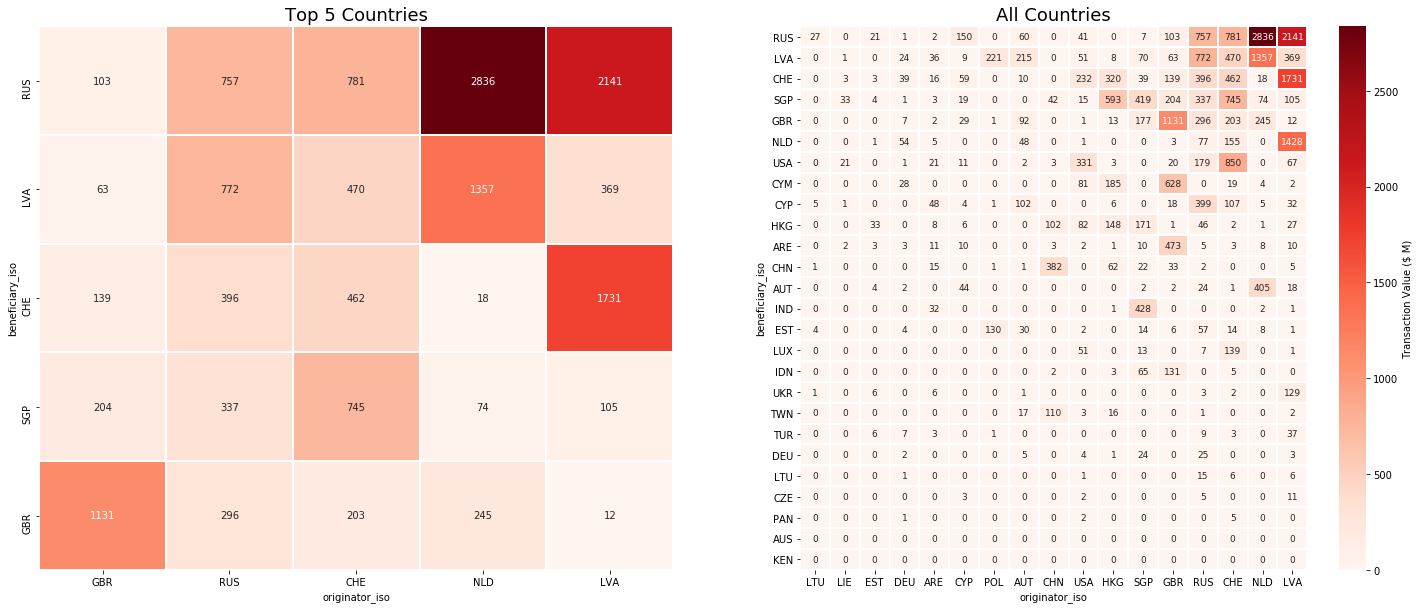

In [26]:
fig,axs = plt.subplots(1,2,figsize=(25,10))

# calculate flow between ISO countries
iso_matrix = pd.crosstab(data['transactions_map']['beneficiary_iso'],
                         data['transactions_map']['originator_iso'],
                         values=data['transactions_map']['amount_transactions'],aggfunc=np.sum)
iso_matrix = iso_matrix.dropna(thresh=10,axis=0).dropna(thresh=10,axis=1) # filter results to top n crossovers
iso_matrix = (iso_matrix/1000000).fillna(0.0) # make $ values in Millions

# sort by total x (originator)
iso_matrix = iso_matrix[iso_matrix.sum(axis=0).sort_values().index]

# sort by total y (benficiary)
iso_matrix = iso_matrix.assign(sort=iso_matrix.sum(axis=1)).sort_values('sort',ascending=False).drop('sort',1)

# plot heatmap
n = 5
sns.heatmap(iso_matrix.iloc[:n,-n:],cmap='Reds',cbar=False,linewidths=1,annot=True,fmt='.0f',ax=axs[0])
sns.heatmap(iso_matrix,cmap='Reds',linewidths=1,annot=True,fmt='.0f',ax=axs[1],
            annot_kws={"size": 9},
            cbar_kws={'label': 'Transaction Value ($ M)'})

# fix y axis limits
for ax,title in zip(axs,[f'Top {n} Countries','All Countries']):
    ax.set_title(title,fontsize=18)
    b, t = ax.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    ax.set_ylim(b, t);

In [9]:
# Cluster example
# pairwise_ dist

***Transaction chains between originators, filers, and beneficiaries***

The transaction chains highlight the parties initiating and facilitating payments. Below are the top 3 transaction chains by value and by volume of transactions.

In [10]:
cols = ['originator_bank_', 'filer_org_name_', 'beneficiary_bank_']
transaction_chains = transactions.groupby(cols).agg({'number_transactions':'sum',
                                                     'amount_transactions':'sum'}).reset_index()

In [11]:
# top chains in terms of transcation value
transaction_chains.sort_values(axis=0,by='amount_transactions',ascending=False)[:3]

,originator_bank_,filer_org_name_,beneficiary_bank_,number_transactions,amount_transactions
102,AMSTERDAM TRADE BANK NV,THE BANK OF NEW YORK MELLON CORP,ROSBANK,4.0,2.747023e+09
1985,RIGENSIS BANK AS,DEUTSCHE BANK AG,ING NETHERLAND NV,47.0,1.201172e+09
1347,ING NETHERLAND NV,DEUTSCHE BANK AG,RIGENSIS BANK AS,33.0,1.199220e+09


In [12]:
# top chains in terms of transaction number.
# Bank of New York Mellon
transaction_chains.sort_values(by='number_transactions',ascending=False)[:3]

,originator_bank_,filer_org_name_,beneficiary_bank_,number_transactions,amount_transactions
139,AS EXPOBANK,THE BANK OF NEW YORK MELLON CORP,CREDIT SUISSE AG,296.0,8.880407e+08
101,AMSTERDAM TRADE BANK NV,STANDARD CHARTERED PLC,RAIFFEISEN BANK INTERNATIONAL AG,190.0,4.026005e+08
701,CIMB BANK BERHAD,THE BANK OF NEW YORK MELLON CORP,BARCLAYS BANK PLC,186.0,1.731369e+08


We can employ several analytical and visualisation techniques to more easily inpsect and unpick the transaction chains. This includes [flow and Sankey diagrams](https://plotly.com/python/sankey-diagram/), and [network analyses]().

In [27]:
#quantile = transaction_chains.groupby(cols)['amount_transactions'].sum().quantile(q=0.9)
filtered = transaction_chains.sort_values(by='number_transactions',ascending=False)[:50]
len(filtered)

50

In [28]:
def df_2_sankey(df,cols,values,hover_value=None):
    """ Helper function to convert a dataframe of relationships to 
        Plotly Sankey format.
    """
    colors = ['#D0EDA6','#EDEF7B','#EF7B84','#00308f','#eedc82','#c66']
    out = df.copy()
    entities = dict()
    vals_ = [values,hover_value]
    try: 
        vals_.remove(None)
    except:
        pass
    
    # get dict of uid for each entity in each level from 0...n
    for n,c in enumerate(cols):
        if n == 0:
            out[f'{c}_'] = pd.factorize(out[c])[0]
        else:
            out[f'{c}_'] = pd.factorize(out[c])[0] + (out[f'{cols[n-1]}_'].max()+1)
        entities[n] = dict(out[[cols[n]+'_',cols[n]]].values)

    # create df edge list between source,targets
    edge_list = list()
    for i in range(0, len(cols), 1):
        slice_ = cols[i:i+2]
        if len(slice_)==2:
            el_ = out.groupby([f'{c}_' for c in slice_],as_index=False)[vals_].sum()
            el_.columns = ['source','target']+vals_
            edge_list.append(el_)
    edge_list = pd.concat(edge_list,ignore_index=True)

    # Sankey node definitions are simply the ordered uid/names of each entity 
    labels = [v[i] for k,v in entities.items() for i in v] # use v[i] for name, i for uid
    node_colors = [colors[k] for k in entities.keys() for i in entities[k]]

    # Sankey edge definitions
    source = list(edge_list['source'])
    target = list(edge_list['target'])
    values = list(edge_list[values])
    if hover_value is None:
        hover_values = list()
    else:
        hover_values = list(edge_list[hover_value])

    if len(source) == len(target) == len(values)==len(hover_values):
        return edge_list,entities,labels,node_colors,source,target,values,hover_values
    else:
        raise Exception('Output test fail: lists are of unequal lengths')

In [29]:
edge_list,entities,labels,colors,source,target,values,hover_values = df_2_sankey(filtered,cols,values='number_transactions',hover_value='amount_transactions')

In [30]:
import plotly.graph_objects as go

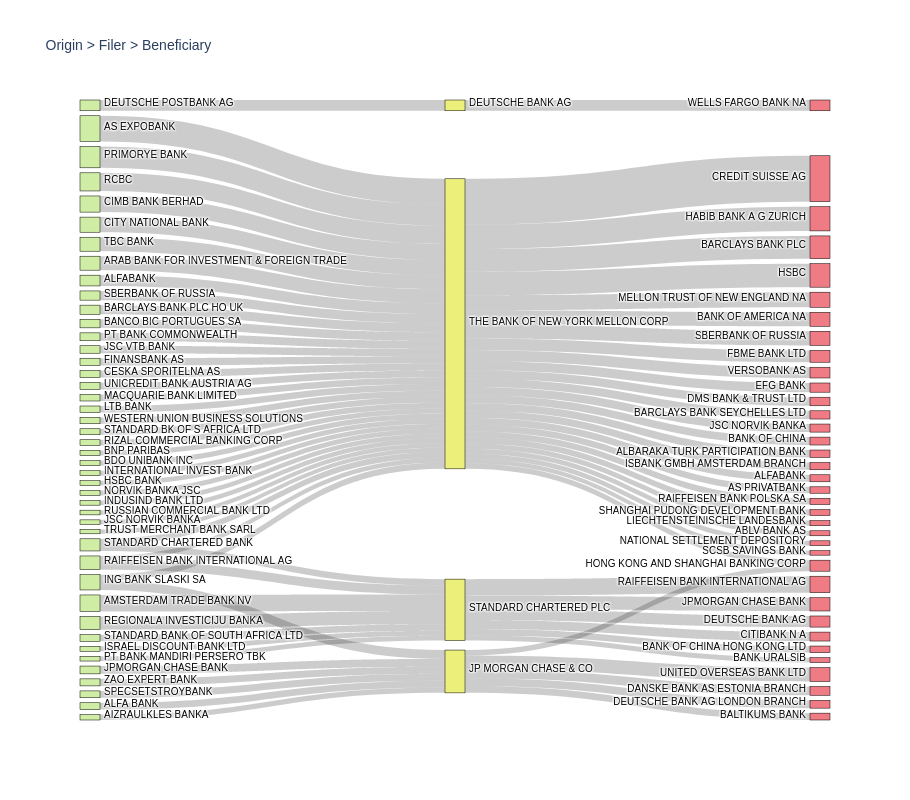

In [51]:
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    node = dict(
      pad = 5,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = colors,
      customdata=hover_values,
      hovertemplate='Source: %{label}<br />'+
                    'Amount: %{value}<br />'+
                    'Transactions: %{customdata}<extra></extra>'
    ),
    link = dict(
      source = source, # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = target,
      value = values,
      customdata=hover_values,
      hovertemplate='Source: %{source.label}<br />'+
                    'Target: %{target.label}<br />'+
                    'Amount: %{value}<br />'+
                    'Transactions: %{customdata}<extra></extra>', 
  ))])

fig.update_layout(autosize=True,width=800,height=800,title_text="Origin > Filer > Beneficiary", font_size=10)
fig.show()

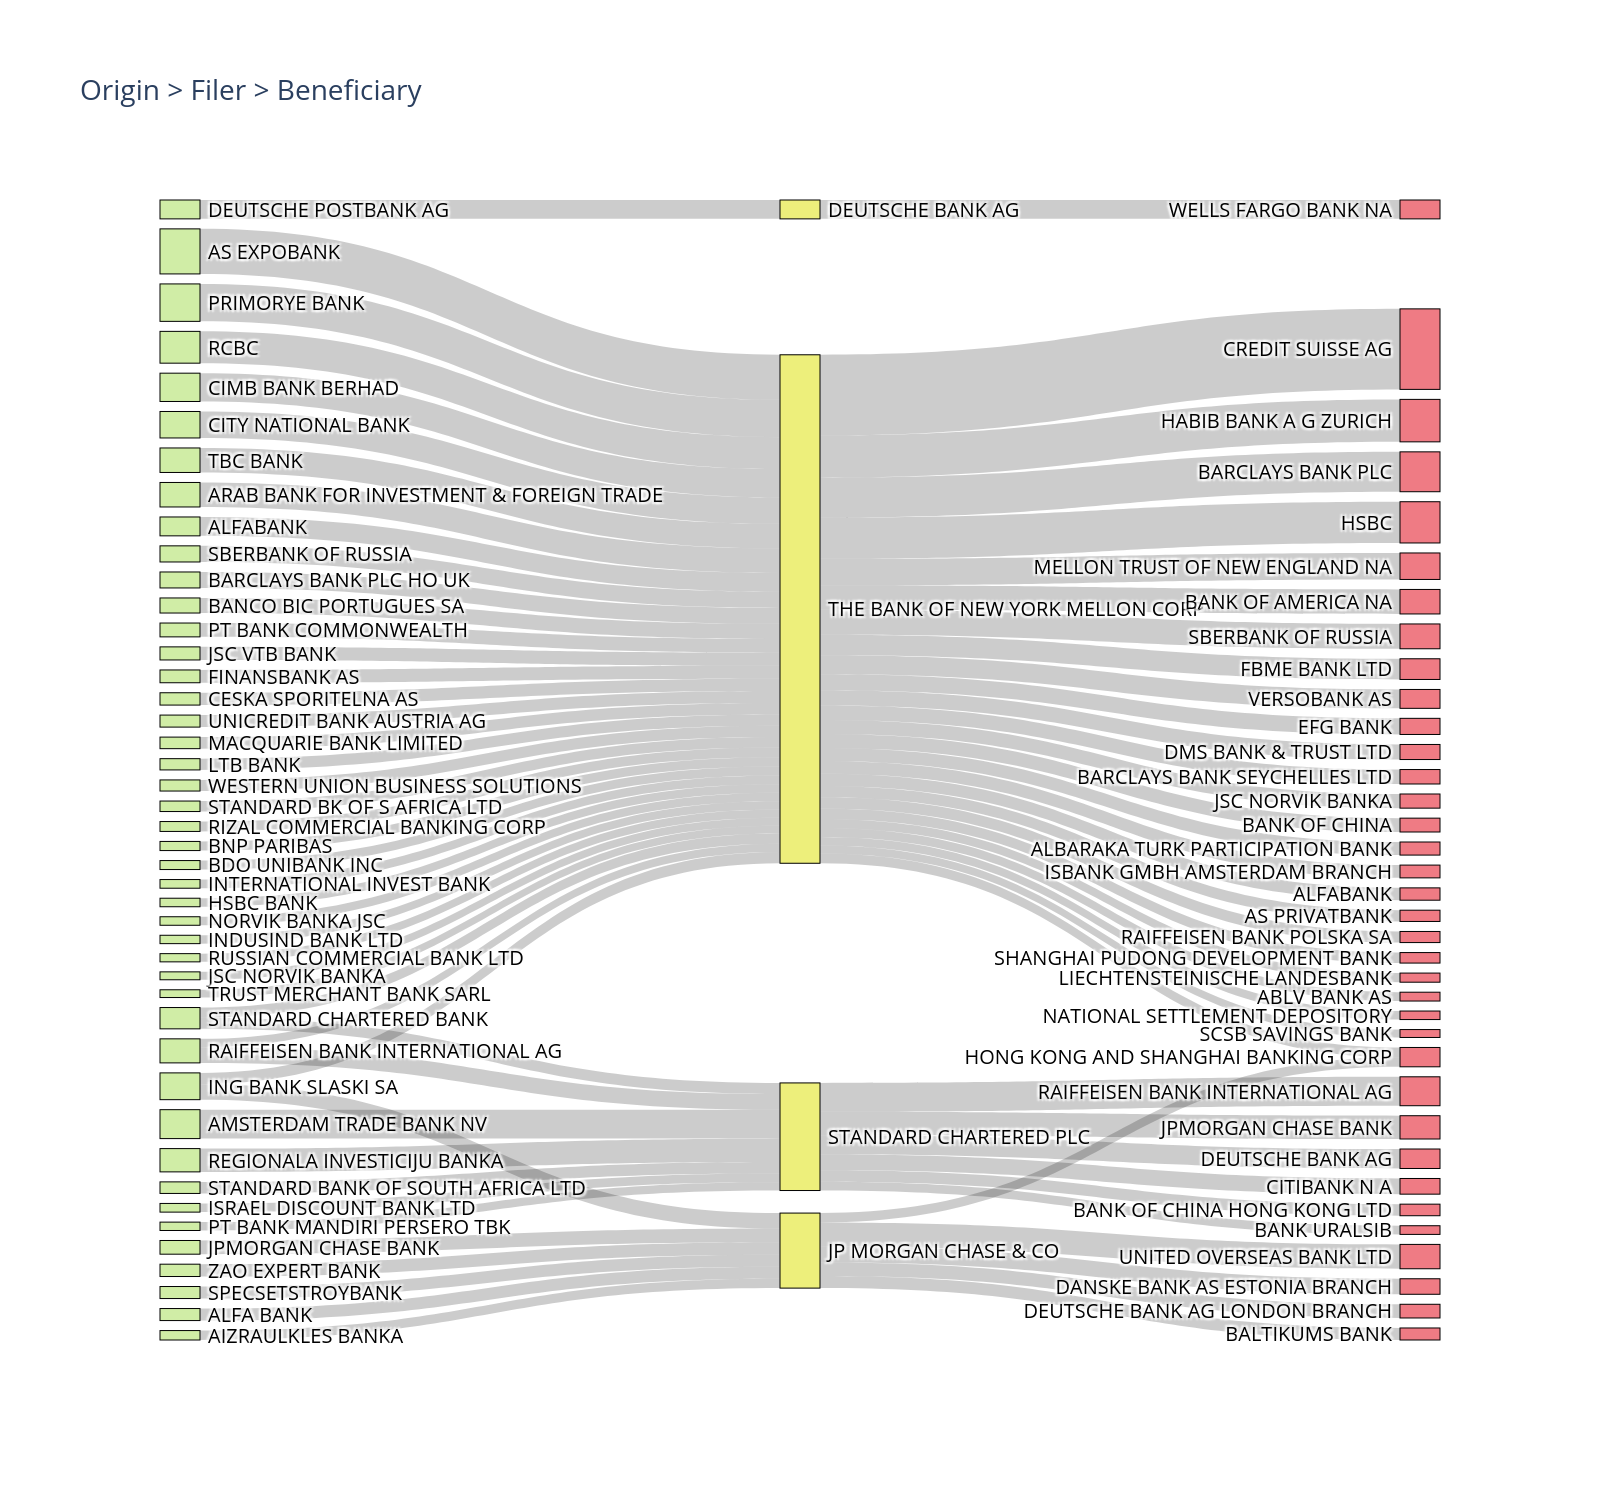

In [49]:
# Output json, html or static image for web and Github
# write to html https://plotly.com/python-api-reference/generated/plotly.io.write_html.html#plotly.io.write_html
# https://plotly.com/python/renderers/
# fig.write_html('test.html')
# fig.show(renderer='svg')

from IPython.display import Image
img_bytes = fig.to_image(format="png", width=800, height=750, scale=2)
Image(img_bytes)

***Map***

In [ ]:
coord_url = "https://gist.githubusercontent.com/tadast/8827699/raw/3cd639fa34eec5067080a61c69e3ae25e3076abb/countries_codes_and_coordinates.csv"
# coord_url = "http://worldmap.harvard.edu/download/wfs/34645/csv?outputFormat=csv&service=WFS&request=GetFeature&format_options=charset%3AUTF-8&typename=geonode%3Acountry_centroids_az8&version=1.0.0"
# coord_url = "https://developers.google.com/public-data/docs/canonical/countries_csv"
coords = pd.read_csv(coord_url,quoting=0)
coords

In [ ]:
# unique countries
iso3 = pd.DataFrame(pd.unique(transactions[['originator_iso','beneficiary_iso']].values.ravel('K')),columns=['iso3'])
iso3[:3]

In [ ]:
coords['Alpha-2 code'].str.replace('"','')

In [ ]:
#!pip install geopip
import geopip

In [ ]:
geopip.absolute_import()

In [ ]:
transaction_flows = transactions.groupby(['originator_iso','beneficiary_iso'])['number_transactions'].sum().reset_index()

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter_geo(iso3, locations="iso3",
                     hover_name="iso3", # column added to hover information
                     projection="natural earth")

for ix,row in transaction_flows.iterrows():
#     print(ix)
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'ISO-3',
            lonsrc = [row['originator_iso'], row['beneficiary_iso']],
            latsrc = [row['originator_iso'], row['beneficiary_iso']],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            #opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
        )
    )
fig.show()

In [ ]:
go.Scattergeo()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scattergeo(
                    locationmode = 'ISO-3',
                    mode = 'markers',
                    ))

fig.show()

References
-----
- [fince data](https://github.com/jexp/fincen)
- [reddit sankey of ](https://www.reddit.com/r/dataisbeautiful/comments/iq5ej4/energy_literacy_saul_griffiths_sankey_diagram_of/)
- [plotly sankey helper](https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0)
- [np.tile()](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)